# Chapter 05 - Image Restoration

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Noise

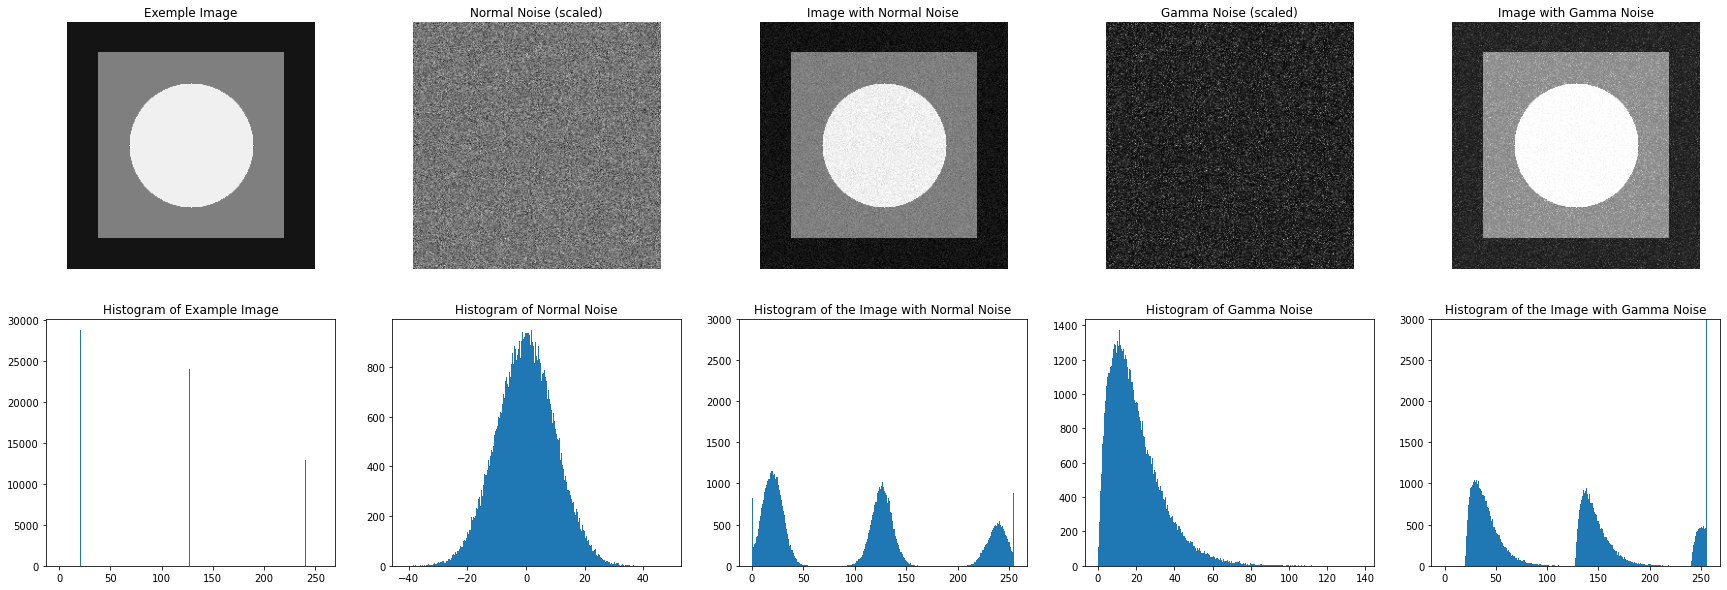

In [2]:
img_size = (256, 256)
plot_y_max = 3000
exemple_src = np.ones(img_size, dtype=np.uint8)*20
exemple_src[32:-32,32:-32] = 127
cv2.circle(exemple_src, (128, 128), 64, (240), -1)

noise_norm  = np.random.normal(loc=0, scale=10, size=img_size)
noise_gamma = np.random.gamma(shape=2, scale=10, size=img_size)  # mean = shape * scale

src_norm  = (exemple_src.astype(np.int) + noise_norm).clip(0, 255).astype(np.uint8)
src_gamma = (exemple_src.astype(np.int) + noise_gamma).clip(0, 255).astype(np.uint8)

plt.figure(figsize=(30,10))
plt.subplot(251);plt.axis('off');plt.title("Exemple Image");plt.imshow(exemple_src, vmin=0, vmax=255, cmap='gray')
plt.subplot(256);plt.title("Histogram of Example Image");plt.hist(exemple_src.ravel(), bins=256, range=(0, 256));
plt.subplot(257);plt.title("Histogram of Normal Noise");plt.hist(noise_norm.ravel(), bins=256);
plt.subplot(259);plt.title("Histogram of Gamma Noise");plt.hist(noise_gamma.ravel(), bins=256);

plt.subplot(252);plt.axis('off');plt.title("Normal Noise (scaled)");plt.imshow(noise_norm, cmap='gray')
plt.subplot(254);plt.axis('off');plt.title("Gamma Noise (scaled)");plt.imshow(noise_gamma, cmap='gray')

plt.subplot(253);plt.axis('off');plt.title("Image with Normal Noise");plt.imshow(src_norm, vmin=0, vmax=255, cmap='gray')
splot = plt.subplot(258);splot.set_ylim(0, plot_y_max);plt.title("Histogram of the Image with Normal Noise");plt.hist(src_norm.ravel(), bins=256);
plt.subplot(255);plt.axis('off');plt.title("Image with Gamma Noise");plt.imshow(src_gamma, vmin=0, vmax=255, cmap='gray')
splot = plt.subplot(2,5,10);splot.set_ylim(0, plot_y_max)
plt.title("Histogram of the Image with Gamma Noise");plt.hist(src_gamma.ravel(), bins=256, range=(0, 256));

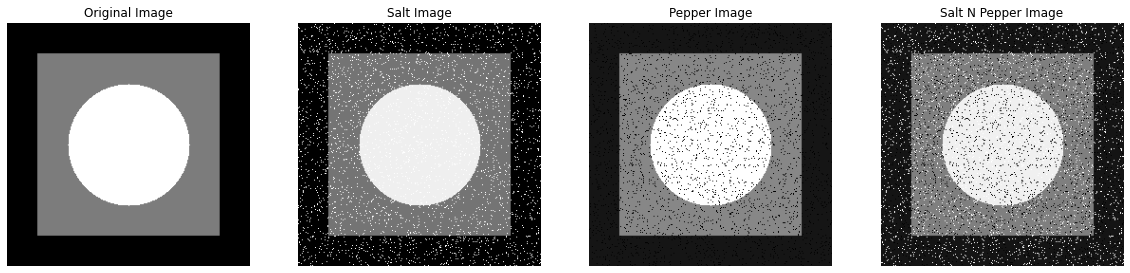

In [3]:
P = 0.1

salt_src  = exemple_src.copy()
pepper_src = exemple_src.copy()
sp_src    = exemple_src.copy()

noise = np.random.rand(*exemple_src.shape)
p_p = noise < P/2
p_s = np.all(((P > noise), (noise  > P/2)),axis=0)

pepper_src[p_p] = 0
salt_src[p_s]  = 255
sp_src[p_p]    = 0
sp_src[p_s]    = 255

plt.figure(figsize=(20, 6))
plt.subplot(141);plt.axis('off');plt.title("Original Image");plt.imshow(exemple_src, cmap='gray')
plt.subplot(142);plt.axis('off');plt.title("Salt Image");plt.imshow(salt_src, cmap='gray')
plt.subplot(143);plt.axis('off');plt.title("Pepper Image");plt.imshow(pepper_src, cmap='gray')
plt.subplot(144);plt.axis('off');plt.title("Salt N Pepper Image");plt.imshow(sp_src, cmap='gray')

# Contraharmonic Mean Filter
Objective: 
    1. Use the Contraharmonic Mean Filter
        A. Salt noise
        B. Pepper noise

In [4]:
def get_contra_harmonic_pixel(src, x, y, Q, M):
    
    numerator   = np.sum(np.power(src[y-M: y+M, x-M:x+M], Q+1))
    denominator = np.sum(np.power(src[y-M: y+M, x-M:x+M], Q))

    if   denominator == 0 and numerator == 0: return 0
    if   denominator == 0 : return 255
    if   numerator   == np.inf and denominator != np.inf: return 255
    if   numerator   == np.inf or denominator == np.inf: return 0
    if   numerator   != numerator or denominator != denominator: return 0 #check nan

    filter_val  = numerator/denominator
    
    return filter_val


def applay_contra_harmonic_filter(src, Q, M):
    src_w_border      = cv2.copyMakeBorder(src, M, M, M, M, borderType=cv2.BORDER_REFLECT)
    dst               = np.ones_like(src_w_border) * 255
    height, width, *_ = src_w_border.shape
    for col in (range(M, width-M)):
        for row in range(M, height-M):
            dst[row, col] = get_contra_harmonic_pixel(src_w_border, col, row, Q, M)
    dst = dst[M:height-M, M:width-M]
    return dst

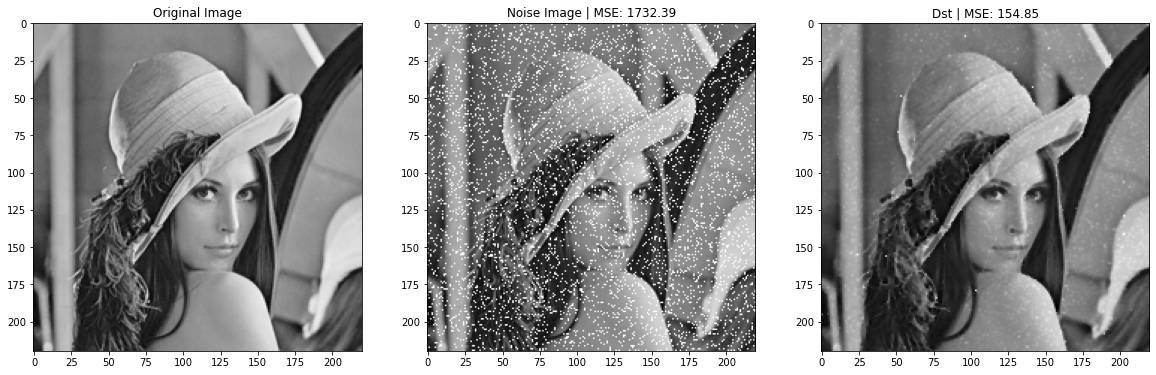

In [5]:
src            = cv2.imread(r'../data/Lenna.png', 0)
noise_src      = src.copy()
P, M, Q        = 0.1, 1, -3.5
noise_prob     = np.random.rand(*src.shape)
noise_val      = noise_prob < P
noise_src[noise_val] = 255

dst       = applay_contra_harmonic_filter(noise_src, Q, M)

mse_noise = np.mean((src.astype(np.int) - noise_src) ** 2)
mse_dst   = np.mean((src.astype(np.int) - dst) ** 2)

plt.figure(figsize=(20,20))
plt.subplot(131);plt.title("Original Image");plt.imshow(src, cmap='gray')
plt.subplot(132);plt.title(f"Noise Image | MSE: {mse_noise:0.2f}");plt.imshow(noise_src, cmap='gray')
plt.subplot(133);plt.title(f"Dst | MSE: {mse_dst:0.2f}");plt.imshow(dst, cmap='gray')

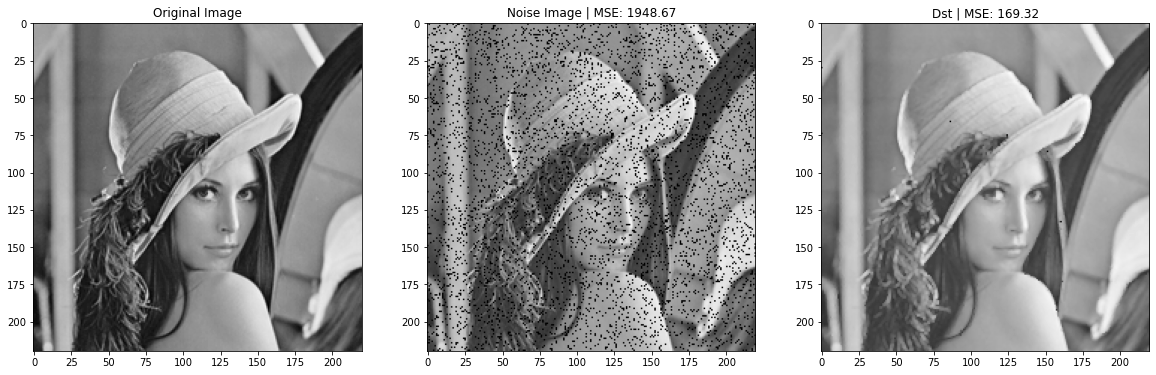

In [6]:
src            = cv2.imread(r'../data/Lenna.png', 0)
noise_src      = src.copy()
P, M, Q        = 0.1, 1, 3.5
noise_prob     = np.random.rand(*src.shape)
noise_val      = noise_prob < P
noise_src[noise_val] = 0

dst       = applay_contra_harmonic_filter(noise_src, Q, M)

mse_noise = np.mean((src.astype(np.int) - noise_src) ** 2)
mse_dst   = np.mean((src.astype(np.int) - dst) ** 2)

plt.figure(figsize=(20,20))
plt.subplot(131);plt.title("Original Image");plt.imshow(src, cmap='gray')
plt.subplot(132);plt.title(f"Noise Image | MSE: {mse_noise:0.2f}");plt.imshow(noise_src, cmap='gray')
plt.subplot(133);plt.title(f"Dst | MSE: {mse_dst:0.2f}");plt.imshow(dst, cmap='gray')

# Adaptive Median Filter
Objective: 
    1. Simulate Salt and Pepper noise
    2. Use the Adaptive Median Filter

In [7]:
def get_salt_pepper_noise(src, P, use_salt=True, use_pepper=True):
    src_noise = src.copy()
    noise     = np.random.rand(*src.shape)
    p_p       = noise < P/2
    p_s       = np.all(((P > noise), (noise  > P/2)),axis=0)
    
    if use_salt:
        src_noise[p_p]  = 0
    if use_pepper:
        src_noise[p_s]  = 255
    return src_noise

def get_neighborhood(src, x, y, m):
    neigh = src[y-m: y+m+1, x-m:x+m+1] 
    return neigh

def get_min_med_max(neigh):
    min_val  = np.min(neigh)
    med_val  = np.median(neigh)
    max_val  = np.max(neigh)
    
    return min_val, med_val, max_val


def adaptive_median_filter(src, M_MAX):
    src_noise_wb      = cv2.copyMakeBorder(src_noise, M_MAX, M_MAX, M_MAX, M_MAX, borderType=cv2.BORDER_REFLECT).astype(np.int)
    dst               = np.zeros_like(src_noise_wb, dtype=np.int)
    height, width, *_ = dst.shape

    for col in (range(M_MAX, width-M_MAX)):
        for row in range(M_MAX, height-M_MAX):
            dst[row, col] = stage_A(src_noise_wb, col, row, M_MAX)
        
    dst = dst[M_MAX:height-M_MAX, M_MAX:width-M_MAX]
    return dst

def stage_A(src, x, y, M_MAX, m=1):
    neigh             = get_neighborhood(src, x, y, m)
    zmin, zmed, zmax  = get_min_med_max(neigh)
    A1 = zmed - zmin
    A2 = zmed - zmax
    if A1 > 0 and A2 < 0:
        return stage_B(src, x, y, m)
    if m < M_MAX:
        return stage_A(src, x, y, M_MAX, m+1)
    else:
        return zmed

def stage_B(src, x, y, m):
    neigh            = get_neighborhood(src, x, y, m)
    zmin, zmed, zmax = get_min_med_max(neigh)
    zcurr            = src[y, x] 
    
    B1 = zcurr - zmin
    B2 = zcurr - zmax
    if B1 > 0 and B2 < 0:
        return zcurr
    return zmed

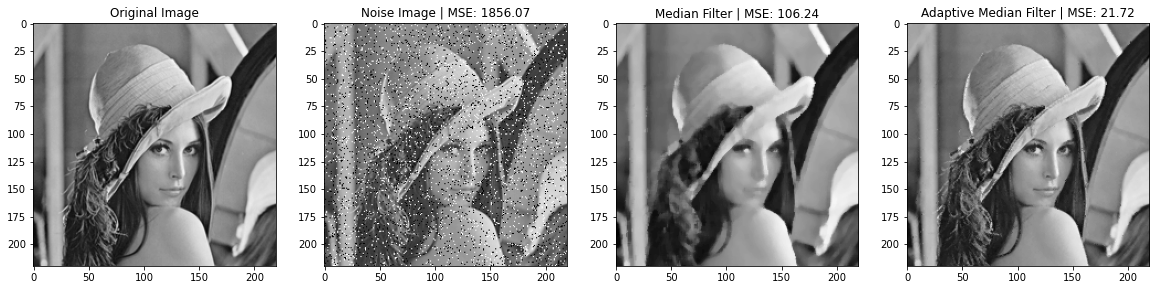

In [8]:
P              = 0.1
M_MAX          = 2

src            = cv2.imread(r'../data/Lenna.png', 0)
src_noise      = get_salt_pepper_noise(src, P)
dst_adpt       = adaptive_median_filter(src_noise, M_MAX)
dst_median     = cv2.medianBlur(src_noise, ksize=(M_MAX * 2) + 1)

mse_noise      = ((src.astype(np.int) - src_noise) ** 2).mean()
mse_adpt       = ((src.astype(np.int) - dst_adpt) ** 2).mean()
mse_median     = ((src.astype(np.int) - dst_median) ** 2).mean()

plt.figure(figsize=(20, 10))
plt.subplot(141);plt.title("Original Image");plt.imshow(src, cmap='gray')
plt.subplot(142);plt.title(f"Noise Image | MSE: {mse_noise:0.2f}");plt.imshow(src_noise, cmap='gray')
plt.subplot(143);plt.title(f"Median Filter | MSE: {mse_median:0.2f}");plt.imshow(dst_median, cmap='gray')
plt.subplot(144);plt.title(f"Adaptive Median Filter | MSE: {mse_adpt:0.2f}");plt.imshow(dst_adpt, cmap='gray')